In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import mean
from numpy import array
from sklearn.metrics import mean_squared_error
import datetime as dt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cleaning the Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Datasets_pipeline/Crime_full_data.csv', index_col = [0])


In [ ]:
data.dropna(how='any', axis=0, inplace=True) 
data = data[data['Year'].between(2014, 2021)]


In [ ]:
data.isna().sum()

Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64

# Feature Engineering (Create day_of_year and week_of_year column)




In [ ]:
data.index = pd.DatetimeIndex(data.Date)
data = data.sort_index()

In [ ]:
data['day_of_year'] = data.index.dayofyear
week_of_year = [math.ceil(i/7) for i in list(data.index.dayofyear)]
data['week_of_year'] = week_of_year

In [ ]:
data['Primary Type'].value_counts()

THEFT                                447846
BATTERY                              378532
CRIMINAL DAMAGE                      220104
ASSAULT                              151252
DECEPTIVE PRACTICE                   128558
OTHER OFFENSE                        128079
NARCOTICS                            114395
BURGLARY                              91523
MOTOR VEHICLE THEFT                   81788
ROBBERY                               76663
CRIMINAL TRESPASS                     48231
WEAPONS VIOLATION                     43714
OFFENSE INVOLVING CHILDREN            16942
PUBLIC PEACE VIOLATION                13154
INTERFERENCE WITH PUBLIC OFFICER       8537
SEX OFFENSE                            7933
CRIM SEXUAL ASSAULT                    7641
PROSTITUTION                           6246
HOMICIDE                               5107
ARSON                                  3666
CRIMINAL SEXUAL ASSAULT                3624
LIQUOR LAW VIOLATION                   1924
STALKING                        

# Primary type based predictions for a crime rate per week

In [ ]:
train_data = data.loc['2014-01-01':'2019-12-31']
test_data = data.loc['2019-01-01':'2019-12-31']

In [ ]:
test_data.head(2)

,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,...,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,day_of_year,week_of_year
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,JC210380,01/01/2019 12:00:00 AM,045XX N BEACON ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,APARTMENT,False,False,1913,...,11,1166351.0,1930230.0,2019,04/06/2019 03:57:03 PM,41.964129,-87.663761,"(41.964129024, -87.663760703)",1,1
2019-01-01,JC326145,01/01/2019 12:00:00 AM,024XX W CARMEN AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,APARTMENT,False,True,2031,...,17,1159097.0,1933800.0,2019,09/13/2019 04:06:54 PM,41.974078,-87.690333,"(41.974077735, -87.690332986)",1,1


In [ ]:
prim_list = data['Primary Type'].value_counts().keys()
prim_list = list(prim_list[:4])
prim_list

['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'ASSAULT']

In [ ]:
train_data_grouped = []
test_data_grouped = []
for prim in prim_list:
    df_train = train_data[train_data['Primary Type'] == prim]
    df_grouped_train = df_train.groupby(['Year', 'week_of_year']).count()
    train_data_grouped.append(list(df_grouped_train['Date'].values))
    df_test = test_data[test_data['Primary Type'] == prim]
    df_grouped_test = df_test.groupby(['Year','week_of_year']).count()
    test_data_grouped.append(list(df_grouped_test['Date'].values))

In [ ]:
def plot_time_series_graphs(test_list,pred_list):
    plt.plot(test_list,color='blue')
    plt.plot(pred_list, color='red')
    plt.legend(["test", "pred"])

## Weighted Moving Average (Primary Type)

Primary Type:  THEFT
Test_values:  [1167, 1126, 999, 923, 926, 1121, 1104, 1018, 940, 953, 1009, 1105, 1043, 1013, 1101, 968, 1157, 1233, 1167, 1207, 1198, 1251, 1330, 1229, 1294, 1420, 1230, 1274, 1375, 1429, 1567, 1357, 1296, 1293, 1367, 1229, 1287, 1261, 1216, 1255, 1192, 1206, 1209, 1155, 989, 1147, 1194, 1146, 1344, 1247, 1272, 1019, 117]
Predicted_values:  [821.0, 876.7333333333333, 930.6, 950.2, 962.6666666666666, 982.5333333333333, 1013.4666666666667, 1041.8, 1042.9333333333334, 1016.8, 993.8666666666667, 987.8, 1021.2, 1033.8666666666666, 1034.8666666666666, 1060.3333333333333, 1031.6, 1068.6, 1127.4666666666667, 1151.6666666666667, 1178.9333333333334, 1196.1333333333334, 1215.6666666666667, 1255.2666666666667, 1254.7333333333333, 1271.7333333333333, 1324.9333333333334, 1300.0, 1291.1333333333334, 1319.6666666666667, 1356.4666666666667, 1430.2666666666667, 1424.2666666666667, 1389.4666666666667, 1352.2, 1345.0666666666666, 1296.0666666666666, 1288.9333333333334, 1277.8, 1254.0

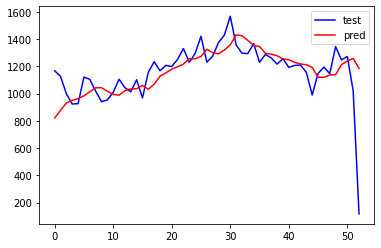

Primary Type:  BATTERY
Test_values:  [962, 819, 747, 745, 732, 827, 907, 804, 791, 854, 973, 926, 974, 974, 839, 970, 918, 1011, 1025, 1095, 1191, 1057, 1138, 1099, 1036, 1161, 1207, 1132, 1060, 1040, 1056, 1063, 996, 1008, 1019, 953, 1099, 1006, 923, 889, 849, 926, 888, 874, 814, 801, 865, 854, 894, 840, 861, 860, 120]
Predicted_values:  [613.1333333333333, 695.4666666666667, 725.6, 733.1333333333333, 747.6, 765.4, 774.0666666666667, 818.4, 822.5333333333333, 818.5333333333333, 832.4666666666667, 877.9333333333333, 898.0, 932.8, 956.2666666666667, 922.5333333333333, 933.4666666666667, 927.2666666666667, 952.6, 980.1333333333333, 1027.6, 1090.0, 1093.0, 1113.7333333333333, 1113.0, 1086.3333333333333, 1105.2666666666667, 1141.5333333333333, 1142.8, 1120.4666666666667, 1094.0666666666666, 1072.7333333333333, 1060.7333333333333, 1036.0, 1024.3333333333333, 1019.8, 994.6666666666666, 1025.0666666666666, 1022.0666666666667, 990.7333333333333, 953.7333333333333, 912.0666666666667, 903.0, 892

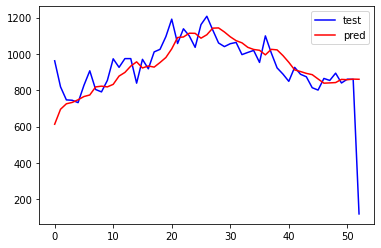

Primary Type:  CRIMINAL DAMAGE
Test_values:  [562, 443, 365, 316, 391, 443, 413, 407, 385, 442, 500, 460, 463, 502, 573, 546, 520, 578, 509, 566, 583, 551, 574, 572, 633, 608, 639, 607, 529, 590, 566, 558, 617, 574, 540, 492, 583, 593, 532, 541, 562, 545, 507, 474, 459, 415, 483, 450, 453, 443, 413, 491, 50]
Predicted_values:  [319.46666666666664, 383.46666666666664, 400.53333333333336, 391.6, 369.53333333333336, 384.1333333333333, 393.3333333333333, 400.46666666666664, 407.6, 404.6, 416.0, 443.3333333333333, 453.53333333333336, 461.6, 478.93333333333334, 512.1333333333333, 527.6, 531.3333333333334, 550.4, 538.8, 545.7333333333333, 558.8, 558.7333333333333, 564.2666666666667, 569.4, 590.6666666666666, 599.1333333333333, 616.2666666666667, 616.8666666666667, 589.2666666666667, 584.8666666666667, 575.3333333333334, 565.9333333333333, 581.6, 582.2666666666667, 568.6, 542.2666666666667, 551.2, 561.8, 553.6666666666666, 551.3333333333334, 555.9333333333333, 550.2, 534.3333333333334, 513.2, 

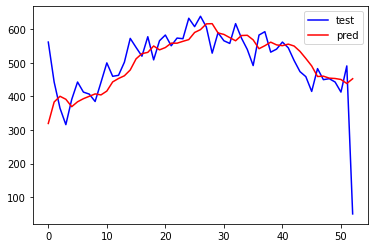

Primary Type:  ASSAULT
Test_values:  [346, 348, 324, 319, 341, 344, 384, 328, 325, 336, 433, 384, 392, 410, 396, 391, 414, 444, 434, 474, 482, 479, 476, 467, 467, 443, 449, 458, 435, 417, 411, 399, 445, 409, 400, 395, 448, 443, 380, 424, 382, 394, 364, 385, 333, 318, 372, 315, 388, 353, 344, 328, 29]
Predicted_values:  [238.86666666666667, 258.06666666666666, 280.73333333333335, 295.73333333333335, 310.4, 333.0, 335.8, 352.06666666666666, 347.26666666666665, 341.2, 338.4, 368.26666666666665, 375.8666666666667, 386.1333333333333, 398.1333333333333, 399.8, 395.8, 402.26666666666665, 416.73333333333335, 424.4, 443.8, 460.6666666666667, 470.46666666666664, 474.93333333333334, 474.26666666666665, 471.4, 461.0, 455.2, 454.4, 447.1333333333333, 436.0, 426.2, 414.53333333333336, 421.53333333333336, 417.4, 412.0, 406.06666666666666, 418.8666666666667, 426.73333333333335, 413.73333333333335, 417.3333333333333, 405.3333333333333, 398.2, 384.6666666666667, 383.4, 364.46666666666664, 346.6, 351.0, 

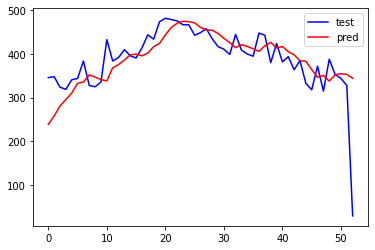

Total RMSE combining all 4 Primary Types: 121.975


In [ ]:
def calc_WMA(test_list,previous):
  pred_list = []
  for ctr in range(len(test_list)):
      length = len(previous)
      y_pred = np.average([previous[i] for i in range(length - 5, length)], weights=[1,2,3,4,5])
      pred_list.append(y_pred)
      previous.append(test_list[ctr])
  return pred_list
    

i=0
test_total=[]
pred_total=[]
for prim in prim_list:
    previous = train_data_grouped[i]
    test_list = test_data_grouped[i]
    pred_list = calc_WMA(test_list,previous)
    test_total = test_total + test_list
    pred_total = pred_total + pred_list
    i+=1
    print('Primary Type: ',prim)
    print('Test_values: ',test_list)
    print('Predicted_values: ',pred_list)
    plot_time_series_graphs(test_list,pred_list)
    plt.show()
print('Total RMSE combining all 4 Primary Types: %.3f' % math.pow(mean_squared_error(pred_total, test_total),.5))

## Exponential Moving Average  (Primary Type)

Community Area:  THEFT
Test_values:  [1167, 1126, 999, 923, 926, 1121, 1104, 1018, 940, 953, 1009, 1105, 1043, 1013, 1101, 968, 1157, 1233, 1167, 1207, 1198, 1251, 1330, 1229, 1294, 1420, 1230, 1274, 1375, 1429, 1567, 1357, 1296, 1293, 1367, 1229, 1287, 1261, 1216, 1255, 1192, 1206, 1209, 1155, 989, 1147, 1194, 1146, 1344, 1247, 1272, 1019, 117]
Predicted_values:  [70.2, 728.28, 966.912, 986.1648, 948.26592, 934.906368, 1046.5625472000002, 1081.02501888, 1043.210007552, 981.2840030208, 964.31360120832, 991.125440483328, 1059.4501761933311, 1049.5800704773324, 1027.632028190933, 1071.652811276373, 1009.4611245105492, 1097.9844498042196, 1178.9937799216877, 1171.797511968675, 1192.91900478747, 1195.9676019149879, 1228.987040765995, 1289.5948163063981, 1253.2379265225593, 1277.6951706090238, 1363.0780682436096, 1283.2312272974439, 1277.6924909189775, 1336.076996367591, 1391.8307985470365, 1496.9323194188146, 1412.9729277675258, 1342.7891711070104, 1312.915668442804, 1345.3662673771214, 12

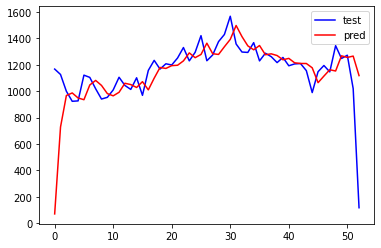

Community Area:  BATTERY
Test_values:  [962, 819, 747, 745, 732, 827, 907, 804, 791, 854, 973, 926, 974, 974, 839, 970, 918, 1011, 1025, 1095, 1191, 1057, 1138, 1099, 1036, 1161, 1207, 1132, 1060, 1040, 1056, 1063, 996, 1008, 1019, 953, 1099, 1006, 923, 889, 849, 926, 888, 874, 814, 801, 865, 854, 894, 840, 861, 860, 120]
Predicted_values:  [72.0, 605.9999999999999, 733.8, 741.72, 743.6880000000001, 736.6752, 790.87008, 860.5480319999999, 826.6192128, 805.2476851199999, 834.499074048, 917.5996296192, 922.63985184768, 953.455940739072, 965.7823762956289, 889.7129505182515, 937.8851802073007, 925.9540720829202, 976.9816288331681, 1005.7926515332672, 1059.317060613307, 1138.3268242453228, 1089.530729698129, 1118.6122918792516, 1106.8449167517006, 1064.3379667006802, 1122.3351866802723, 1173.134074672109, 1148.4536298688436, 1095.3814519475375, 1062.152580779015, 1058.461032311606, 1061.1844129246424, 1022.073765169857, 1013.6295060679428, 1016.8518024271771, 978.5407209708708, 1050.816288

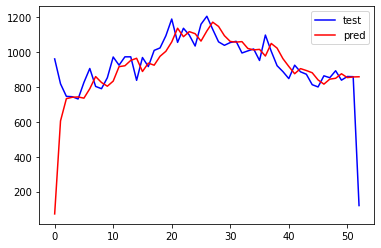

Community Area:  CRIMINAL DAMAGE
Test_values:  [562, 443, 365, 316, 391, 443, 413, 407, 385, 442, 500, 460, 463, 502, 573, 546, 520, 578, 509, 566, 583, 551, 574, 572, 633, 608, 639, 607, 529, 590, 566, 558, 617, 574, 540, 492, 583, 593, 532, 541, 562, 545, 507, 474, 459, 415, 483, 450, 453, 443, 413, 491, 50]
Predicted_values:  [30.0, 349.2, 405.48, 381.192, 342.0768, 371.43072, 414.372288, 413.5489152, 409.61956608, 394.84782643200003, 423.1391305728, 469.25565222912, 463.70226089164805, 463.2809043566592, 486.5123617426637, 538.4049446970655, 542.9619778788262, 529.1847911515305, 558.4739164606121, 528.7895665842449, 551.1158266336979, 570.2463306534792, 558.6985322613916, 567.8794129045566, 570.3517651618226, 607.940706064729, 607.9762824258917, 626.5905129703567, 614.8362051881427, 563.334482075257, 579.3337928301028, 571.3335171320412, 563.3334068528166, 595.5333627411267, 582.6133450964506, 557.0453380385802, 518.018135215432, 557.0072540861729, 578.6029016344692, 550.6411606537

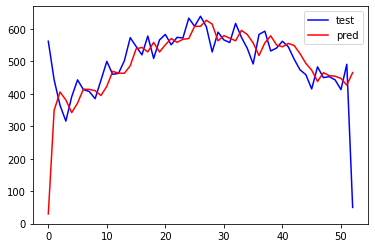

Community Area:  ASSAULT
Test_values:  [346, 348, 324, 319, 341, 344, 384, 328, 325, 336, 433, 384, 392, 410, 396, 391, 414, 444, 434, 474, 482, 479, 476, 467, 467, 443, 449, 458, 435, 417, 411, 399, 445, 409, 400, 395, 448, 443, 380, 424, 382, 394, 364, 385, 333, 318, 372, 315, 388, 353, 344, 328, 29]
Predicted_values:  [17.4, 214.56, 294.624, 312.2496, 316.29984, 331.119936, 338.8479744, 365.93918976, 343.17567590399995, 332.27027036159996, 334.50810814464, 393.603243257856, 387.84129730314237, 390.3365189212569, 402.1346075685028, 398.45384302740115, 393.9815372109605, 405.9926148843842, 428.7970459537537, 431.91881838150147, 457.1675273526006, 472.0670109410402, 476.2268043764161, 476.09072175056644, 470.6362887002266, 468.45451548009066, 453.1818061920363, 450.6727224768145, 455.06908899072585, 443.02763559629034, 427.41105423851616, 417.5644216954065, 406.4257686781626, 429.5703074712651, 417.228122988506, 406.89124919540245, 399.756499678161, 428.7025998712644, 437.2810399485058

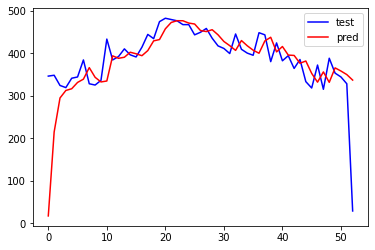

Total RMSE combining all 4 Primary Types: 156.965


In [ ]:
def calc_EMA(test_list,previous):
  pred_list = []
  previous_prediction = 0
  for ctr in range(len(test_list)):
      y_pred = ((1-0.6)*previous_prediction + (0.6*previous[-1])) # 0.6 as smoothing value
      previous_prediction = y_pred
      pred_list.append(y_pred)
      previous.append(test_list[ctr])
  return pred_list
  
i=0
test_total = []
pred_total = []
for prim in prim_list:
    previous = train_data_grouped[i]
    test_list = test_data_grouped[i]
    pred_list = []
    pred_list = calc_EMA(test_list,previous)
    test_total = test_total + test_list
    pred_total = pred_total + pred_list
    i+=1
    print('Community Area: ',prim)
    print('Test_values: ',test_list)
    print('Predicted_values: ',pred_list)
    plot_time_series_graphs(test_list,pred_list)
    plt.show()
print('Total RMSE combining all 4 Primary Types: %.3f' % math.pow(mean_squared_error(pred_total, test_total),.5))

# Community area based predictions for each day

In [ ]:
df_comm = pd.read_csv('/content/drive/MyDrive/Datasets_pipeline/community_area_map.csv', index_col = [0])
df_comm.head(2)
df_comm = df_comm.reset_index()
df_comm.columns = ['Community Area','Community Area Name', 'Population']

In [ ]:
data_merged = pd.merge(data, df_comm,  how='left', left_on=['Community Area'], right_on = ['Community Area'])

In [ ]:
data_merged.columns

Index(['Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
       'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate',
       'Year', 'Updated On', 'Latitude', 'Longitude', 'Location',
       'day_of_year', 'week_of_year', 'Community Area Name', 'Population'],
      dtype='object')

In [ ]:
data_merged.index = pd.DatetimeIndex(data_merged.Date)
data_merged = data_merged.sort_index()

In [ ]:
data_merged['day_of_year'] = data_merged.index.dayofyear
week_of_year = [math.ceil(i/7) for i in list(data_merged.index.dayofyear)]
data_merged['week_of_year'] = week_of_year

In [ ]:
train_data = data_merged.loc['2014-01-01':'2019-12-31']
test_data = data_merged.loc['2019-01-01':'2019-12-31']

In [ ]:
comm_list = data_merged['Community Area'].value_counts().keys()
comm_list = list(comm_list[:4])
comm_list

[25.0, 8.0, 43.0, 29.0]

In [ ]:
train_data_grouped = []
test_data_grouped = []
for comm in comm_list:
    df_train = train_data[train_data['Community Area'] == comm]
    df_grouped_train = df_train.groupby(['Year', 'week_of_year']).count()
    train_data_grouped.append(list(df_grouped_train['Date'].values))
    df_test = test_data[test_data['Community Area'] == comm]
    df_grouped_test = df_test.groupby(['Year','week_of_year']).count()
    test_data_grouped.append(list(df_grouped_test['Date'].values))

In [ ]:
df_train.groupby(['Year', 'week_of_year']).count()

Case Number  Date  Block  IUCR  Primary Type  Description  \
Year week_of_year                                                              
2014 1                     128   128    128   128           128          128   
     2                     128   128    128   128           128          128   
     3                     125   125    125   125           125          125   
     4                     127   127    127   127           127          127   
     5                     139   139    139   139           139          139   
...                        ...   ...    ...   ...           ...          ...   
2019 49                    176   176    176   176           176          176   
     50                    139   139    139   139           139          139   
     51                    168   168    168   168           168          168   
     52                    154   154    154   154           154          154   
     53                     14    14     14    14            14           14   

                   Location Description  Arrest  Domestic  Beat  ...  \
Year week_of_year                                                ...   
2014 1                              128     128       128   128  ...   
     2                              128     128       128   128  ...   
     3                              125     125       125   125  ...   
     4                              127     127       127   127  ...   
     5                              139     139       139   139  ...   
...                                 ...     ...       ...   ...  ...   
2019 49                             176     176       176   176  ...   
     50                             139     139       139   139  ...   
     51                             168     168       168   168  ...   
     52                             154     154       154   154  ...   
     53                              14      14        14    14  ...   

                   FBI Code  X Coordinate  Y Coordinate  Updated On  Latitude  \
Year week_of_year                                                               
2014 1                  128           128           128         128       128   
     2                  128           128           128         128       128   
     3                  125           125           125         125       125   
     4                  127           127           127         127       127   
     5                  139           139           139         139       139   
...                     ...           ...           ...         ...       ...   
2019 49                 176           176           176         176       176   
     50                 139           139           139         139       139   
     51                 168           168           168         168       168   
     52                 154           154           154         154       154   
     53                  14            14            14          14        14   

                   Longitude  Location  day_of_year  Community Area Name  \
Year week_of_year                                                          
2014 1                   128       128          128                  128   
     2                   128       128          128                  128   
     3                   125       125          125                  125   
     4                   127       127          127                  127   
     5                   139       139          139                  139   
...                      ...       ...          ...                  ...   
2019 49                  176       176          176                  176   
     50                  139       139          139                  139   
     51                  168       168          168                  168   
     52                  154       154          154                  154   
     53                   14        14           14                   14   

## Weighted Moving Average (Community Area)



Community Area:  25.0
Test_values:  [292, 255, 220, 217, 223, 246, 241, 211, 252, 260, 265, 282, 291, 266, 305, 297, 282, 321, 275, 296, 332, 323, 315, 298, 295, 315, 366, 351, 308, 341, 327, 289, 300, 294, 307, 265, 291, 287, 330, 258, 277, 261, 279, 239, 274, 253, 269, 268, 245, 232, 289, 260, 35]
Predicted_values:  [186.06666666666666, 212.66666666666666, 223.8, 221.73333333333332, 223.26666666666668, 229.66666666666666, 231.2, 234.13333333333333, 228.0, 236.13333333333333, 244.6, 252.26666666666668, 264.3333333333333, 276.6666666666667, 275.3333333333333, 286.06666666666666, 291.1333333333333, 289.06666666666666, 300.0, 293.6, 293.6, 306.2, 313.46666666666664, 315.3333333333333, 311.93333333333334, 306.0, 306.8, 325.73333333333335, 336.8, 331.1333333333333, 335.8, 332.73333333333335, 316.2, 308.46666666666664, 302.1333333333333, 301.06666666666666, 288.26666666666665, 288.26666666666665, 286.8, 300.53333333333336, 287.8666666666667, 284.8, 275.6, 274.4, 260.4, 264.1333333333333, 25

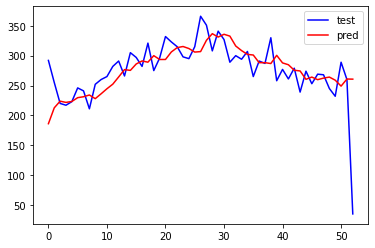

Community Area:  8.0
Test_values:  [268, 222, 218, 186, 205, 256, 244, 206, 177, 217, 254, 234, 206, 249, 249, 208, 253, 229, 251, 242, 253, 241, 273, 284, 270, 270, 287, 258, 262, 235, 297, 241, 261, 213, 226, 192, 231, 230, 248, 231, 220, 243, 265, 218, 231, 241, 231, 217, 234, 258, 255, 183, 26]
Predicted_values:  [158.46666666666667, 184.06666666666666, 192.06666666666666, 201.13333333333333, 202.0, 209.0, 221.06666666666666, 229.93333333333334, 224.66666666666666, 210.53333333333333, 210.33333333333334, 221.66666666666666, 226.46666666666667, 222.6, 233.06666666666666, 238.73333333333332, 228.6, 236.53333333333333, 235.2, 239.66666666666666, 241.0, 246.46666666666667, 244.93333333333334, 254.86666666666667, 265.53333333333336, 269.3333333333333, 271.26666666666665, 277.73333333333335, 271.46666666666664, 267.53333333333336, 256.06666666666666, 267.6, 258.6666666666667, 259.46666666666664, 244.06666666666666, 236.26666666666668, 217.73333333333332, 219.2, 221.0, 230.86666666666667,

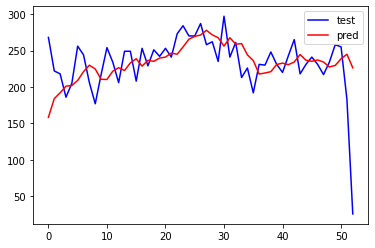

Community Area:  43.0
Test_values:  [185, 161, 145, 133, 152, 147, 174, 170, 134, 169, 142, 157, 150, 188, 135, 155, 171, 172, 157, 178, 178, 170, 171, 182, 163, 181, 187, 178, 196, 191, 145, 166, 161, 170, 189, 150, 210, 179, 170, 174, 150, 142, 160, 154, 161, 156, 191, 175, 159, 148, 162, 152, 21]
Predicted_values:  [110.26666666666667, 129.13333333333333, 138.26666666666668, 141.2, 141.26666666666668, 148.93333333333334, 146.2, 155.0, 161.6, 154.53333333333333, 159.06666666666666, 153.46666666666667, 153.2, 151.73333333333332, 164.26666666666668, 155.53333333333333, 155.73333333333332, 160.4, 164.46666666666667, 162.06666666666666, 168.73333333333332, 172.53333333333333, 172.13333333333333, 172.13333333333333, 175.86666666666667, 171.6, 174.33333333333334, 178.86666666666667, 179.26666666666668, 185.2, 188.53333333333333, 174.66666666666666, 170.2, 165.46666666666667, 164.86666666666667, 172.33333333333334, 166.93333333333334, 181.2, 182.2, 179.0, 177.13333333333333, 168.26666666666

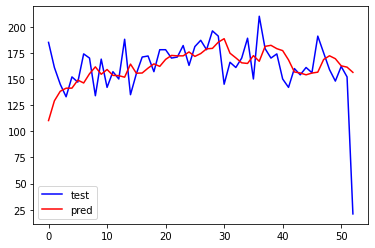

Community Area:  29.0
Test_values:  [207, 186, 158, 151, 123, 157, 161, 175, 157, 178, 161, 184, 174, 174, 178, 191, 158, 176, 167, 168, 168, 170, 184, 164, 180, 198, 162, 201, 185, 200, 164, 218, 200, 212, 162, 175, 181, 170, 165, 173, 168, 168, 156, 167, 182, 144, 151, 133, 176, 139, 168, 154, 14]
Predicted_values:  [109.6, 135.2, 151.73333333333332, 155.8, 158.2, 151.46666666666667, 148.8, 150.8, 159.13333333333333, 160.33333333333334, 168.13333333333333, 166.6, 172.46666666666667, 173.46666666666667, 174.53333333333333, 175.8, 181.4, 174.0, 174.33333333333334, 171.53333333333333, 169.53333333333333, 168.2, 169.06666666666666, 173.8, 171.33333333333334, 174.4, 182.66666666666666, 176.93333333333334, 184.73333333333332, 186.06666666666666, 191.0, 182.6, 194.46666666666667, 196.6, 202.8, 190.53333333333333, 185.13333333333333, 181.0, 175.66666666666666, 170.66666666666666, 171.46666666666667, 169.86666666666667, 168.73333333333332, 164.46666666666667, 164.8, 170.0, 161.93333333333334,

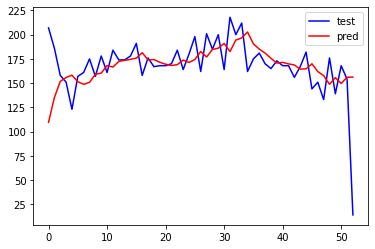

Total RMSE combining all 4 community areas: 35.061


In [ ]:
def calc_WMA(test_list,previous):
  pred_list = []
  for ctr in range(len(test_list)):
      length = len(previous)
      y_pred = np.average([previous[i] for i in range(length - 5, length)], weights=[1,2,3,4,5])
      pred_list.append(y_pred)
      previous.append(test_list[ctr])
  return pred_list
    

i=0
test_total=[]
pred_total=[]
for comm in comm_list:
    previous = train_data_grouped[i]
    test_list = test_data_grouped[i]
    pred_list = calc_WMA(test_list,previous)
    test_total = test_total + test_list
    pred_total = pred_total + pred_list
    i+=1
    print('Community Area: ',comm)
    print('Test_values: ',test_list)
    print('Predicted_values: ',pred_list)
    plot_time_series_graphs(test_list,pred_list)
    plt.show()
print('Total RMSE combining all 4 community areas: %.3f' % math.pow(mean_squared_error(pred_total, test_total),.5))

## Exponential Moving average (Community Area)





Community Area:  25.0
Test_values:  [292, 255, 220, 217, 223, 246, 241, 211, 252, 260, 265, 282, 291, 266, 305, 297, 282, 321, 275, 296, 332, 323, 315, 298, 295, 315, 366, 351, 308, 341, 327, 289, 300, 294, 307, 265, 291, 287, 330, 258, 277, 261, 279, 239, 274, 253, 269, 268, 245, 232, 289, 260, 35]
Predicted_values:  [21.0, 183.6, 226.44, 222.57600000000002, 219.2304, 221.49215999999998, 236.196864, 239.0787456, 222.23149824, 240.092599296, 252.03703971840002, 259.81481588736, 273.125926354944, 283.8503705419776, 273.14014821679103, 292.25605928671644, 295.10242371468655, 287.24096948587464, 307.49638779434986, 287.99855511773995, 292.79942204709596, 316.3197688188384, 320.32790752753533, 317.1311630110141, 305.65246520440564, 299.26098608176227, 308.70439443270493, 343.08175777308196, 347.8327031092328, 323.9330812436931, 334.1732324974772, 329.8692929989909, 305.34771719959633, 302.13908687983854, 297.2556347519354, 303.10225390077414, 280.2409015603097, 286.6963606241239, 286.87854

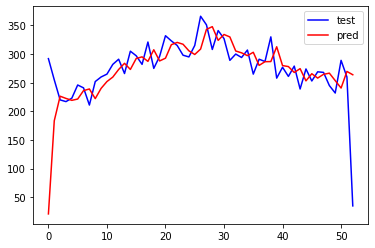

Community Area:  8.0
Test_values:  [268, 222, 218, 186, 205, 256, 244, 206, 177, 217, 254, 234, 206, 249, 249, 208, 253, 229, 251, 242, 253, 241, 273, 284, 270, 270, 287, 258, 262, 235, 297, 241, 261, 213, 226, 192, 231, 230, 248, 231, 220, 243, 265, 218, 231, 241, 231, 217, 234, 258, 255, 183, 26]
Predicted_values:  [15.6, 167.04, 200.016, 210.8064, 195.92256, 201.36902400000002, 234.1476096, 240.05904384000002, 219.623617536, 194.04944701440002, 207.81977880576, 235.527911522304, 234.61116460892163, 217.44446584356865, 236.37778633742747, 243.951114534971, 222.3804458139884, 240.75217832559534, 233.70087133023816, 244.08034853209526, 242.8321394128381, 248.93285576513523, 244.1731423060541, 261.46925692242166, 274.9877027689687, 271.99508110758745, 270.79803244303497, 280.519212977214, 267.0076851908856, 264.0030740763542, 246.6012296305417, 276.8404918522167, 255.3361967408867, 258.7344786963547, 231.2937914785419, 228.11751659141675, 206.4470066365667, 221.17880265462668, 226.47152

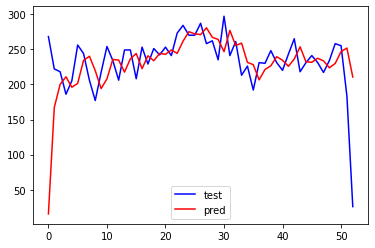

Community Area:  43.0
Test_values:  [185, 161, 145, 133, 152, 147, 174, 170, 134, 169, 142, 157, 150, 188, 135, 155, 171, 172, 157, 178, 178, 170, 171, 182, 163, 181, 187, 178, 196, 191, 145, 166, 161, 170, 189, 150, 210, 179, 170, 174, 150, 142, 160, 154, 161, 156, 191, 175, 159, 148, 162, 152, 21]
Predicted_values:  [12.6, 116.04, 143.016, 144.2064, 137.48256, 146.193024, 146.67720960000003, 163.07088384000002, 167.22835353600001, 147.2913414144, 160.31653656575998, 149.32661462630398, 153.9306458505216, 151.57225834020863, 173.42890333608347, 150.3715613344334, 153.14862453377336, 163.85944981350934, 168.74377992540374, 161.6975119701615, 171.4790047880646, 175.39160191522583, 172.15664076609033, 171.46265630643614, 177.78506252257446, 168.91402500902979, 176.1656100036119, 182.66624400144477, 179.8664976005779, 189.54659904023117, 190.41863961609246, 163.167455846437, 164.86698233857481, 162.54679293542992, 167.01871717417197, 180.2074868696688, 162.08299474786753, 190.833197899147

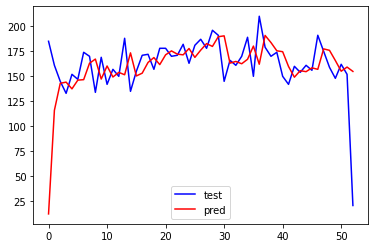

Community Area:  29.0
Test_values:  [207, 186, 158, 151, 123, 157, 161, 175, 157, 178, 161, 184, 174, 174, 178, 191, 158, 176, 167, 168, 168, 170, 184, 164, 180, 198, 162, 201, 185, 200, 164, 218, 200, 212, 162, 175, 181, 170, 165, 173, 168, 168, 156, 167, 182, 144, 151, 133, 176, 139, 168, 154, 14]
Predicted_values:  [8.4, 127.55999999999999, 162.624, 159.8496, 154.53984, 135.615936, 148.44637440000002, 155.97854976000002, 167.391419904, 161.1565679616, 171.26262718464, 165.105050873856, 176.4420203495424, 174.97680813981697, 174.3907232559268, 176.55628930237071, 185.22251572094828, 168.8890062883793, 173.15560251535172, 169.4622410061407, 168.58489640245628, 168.2339585609825, 169.293583424393, 178.11743336975718, 169.64697334790287, 175.85878933916115, 189.14351573566447, 172.8574062942658, 189.7429625177063, 186.89718500708253, 194.758874002833, 176.3035496011332, 201.32141984045325, 200.5285679361813, 207.41142717447252, 180.16457086978903, 177.0658283479156, 179.42633133916624, 

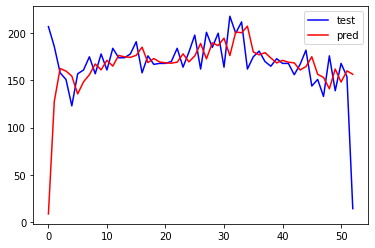

Total RMSE combining all 4 Primary Types: 45.619


In [ ]:
def calc_EMA(test_list,previous):
  pred_list = []
  previous_prediction = 0
  for ctr in range(len(test_list)):
      y_pred = ((1-0.6)*previous_prediction + (0.6*previous[-1])) # 0.6 as smoothing value
      previous_prediction = y_pred
      pred_list.append(y_pred)
      previous.append(test_list[ctr])
  return pred_list

i=0
test_total = []
pred_total = []
for comm in comm_list:
    previous = train_data_grouped[i]
    test_list = test_data_grouped[i]
    pred_list = calc_EMA(test_list,previous)
    test_total = test_total + test_list
    pred_total = pred_total + pred_list
    i+=1
    print('Community Area: ',comm)
    print('Test_values: ',test_list)
    print('Predicted_values: ',pred_list)
    plot_time_series_graphs(test_list,pred_list)
    plt.show()
print('Total RMSE combining all 4 Primary Types: %.3f' % math.pow(mean_squared_error(pred_total, test_total),.5))